#GAN to generate faces

##Environment  setup
First we need to set up the enviroment importing all necessary libraries

In [ ]:
import os
import cv2
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D

This section defines a function that converts the elapsed time since the start of training (in seconds) into a user-readable string format, in hours, minutes, and seconds. This will be useful to show the elapsed time during the GAN training.

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

Now we are trying to mount the Google Drive in case Google Colab is being used. If the Google Drive mount is successful, the COLAB variable will be set to True and "success" will be printed. Otherwise, the COLAB variable will be set to False and "failure" will be printed. Also, it is making sure that the TensorFlow version is 2.x if Google Colab is being used.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("success")
    %tensorflow_version 2.x
except:
    print("failure")
    COLAB = False

Mounted at /content/drive
success
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


##Variables 
We define several constants that will be used in the rest of the code:

In [ ]:
GENERATE_RES = 3 
# Generation resolution factor (more than 4, google colab explotes)
# A resolution factor for image generation. 
#In this case, it has been set to 3, which means that the generated images will have a resolution of 96x96 pixels
# (1=32, 2=64, 3=96, 4=128, etc.)

GENERATE_SQUARE = 32 * GENERATE_RES 
# The number of rows and columns the generated images will have. 
# It is set to 32 * GENERATE_RES, which means that in this case, each generated image will be 96x96 pixels. 
# rows/cols (should be square)

IMAGE_CHANNELS = 3
# The number of color channels of the images. 
# Set to 3, which means that the images will be in color (red, green, and blue).

PREVIEW_ROWS = 4
# The number of rows to use to display a preview of the images generated during training.

PREVIEW_COLS = 7
# The number of columns to use to display a preview of the images generated during training.

PREVIEW_MARGIN = 16
# The margin (in pixels) to use to separate the images in the preview.

SEED_SIZE = 100
# The size of the seed vector to use for generating images.

DATA_PATH = '/content/drive/MyDrive/datasets/images'
# The path where the dataset used to train the model is located.

EPOCHS = 100
# The path where the dataset used to train the model is located.

BATCH_SIZE = 32
# The batch size to use to train the model.

BUFFER_SIZE = 60000
# The size of the buffer to use for shuffling the data set.

##Data set preprocessing
This code block is responsible for loading and preprocessing the dataset. It first checks if a preprocessed binary file of the dataset exists at the given path. If it does not exist, the code block loads the original images from a directory, resizes them to the specified **GENERATE_SQUARE** size, and appends them to a list **training_data**. The images are then reshaped to have 4 dimensions and are converted to float32 data type. The pixel values are normalized to be between -1 and 1. Finally, the preprocessed dataset is saved as a binary file at the specified path. If the binary file already exists, it is loaded directly into **training_data**.

It is worth noting that this dataset preprocessing can take a long time (over an hour), especially for large datasets or high resolution images. Therefore, it is a good idea to save the preprocessed dataset as a binary file for future use.

In [ ]:
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = '/content/drive/MyDrive/datasets/output'
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/drive/MyDrive/datasets/images/training_data_96_96.npy
Loading previous training pickle...


##Training TensorFlow dataset
Here we create a TensorFlow Dataset object from the preprocessed **training_data** array. 

The dataset is created using **tf.data.Dataset.from_tensor_slices()** which takes a tensor-like object and creates a dataset containing slices of that tensor as elements. In this case, each element in the dataset will be a single image from the training_data array.

The dataset is then shuffled using **shuffle()** method with a buffer size of **BUFFER_SIZE**. This means that a buffer of **BUFFER_SIZE** elements is used to randomly sample the next element to be included in the batch. This helps to add some randomness to the order in which the images are presented during training, which can improve the training process.

Finally, the dataset is batched using **batch()** method with a batch size of **BATCH_SIZE**. This means that each element in the dataset will be a batch of **BATCH_SIZE** images. The train_dataset object can now be used for training the GAN model.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

##Generator
This function defines the generator neural network architecture, which takes in a random seed of size **seed_size** and generates an image with channels number of color channels.

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()#Here we define a sequential Keras model that will be used to build the generating network.

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))#This is the first layer of the generator network 
    model.add(Reshape((4,4,256)))# the shape of the tensor is changed to (4,4,256) so that it can be used in convolutional layers.

# image resolution from (4.4) to (8.8).
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same")) # a convolutional layer is added
    model.add(BatchNormalization(momentum=0.8))# A batch normalization layer is added to speed up network training and avoid covariate shift problems
    model.add(Activation("relu"))# ReLU activation is used to introduce non-linearities into the network.

# image resolution from (8.8) to (16.16).
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
# image resolution from (16.16) to (32.32).
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


##Discriminator
This is a discriminator model generator, which is a convolutional neural network designed to identify fake images generated by the generator. This is achieved by training the discriminator model to distinguish between the generated images and the actual images.

In [ ]:
def build_discriminator(image_shape):
    model = Sequential() # Initializes an instance of a Keras sequential model, which is a type of model that is made up of multiple layers stacked on top of each other

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))# Adds a 2D convolution layer with 32 filters, 3x3 kernel size, one stride of 2 and an input size image_shape to the model.
                                    # The convolution layer is used to extract features from the input image.
    model.add(LeakyReLU(alpha=0.2)) # Adds a LeakyReLU activation layer with an alpha of 0.2. 
                                    # LeakyReLU is an activation function in convolutional neural networks, allowing gradient flow when the unit is inactive.

    model.add(Dropout(0.25)) # Adds a dropout layer, which is used to regularize the model by avoiding overfitting by randomly removing some neural connections during training
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same")) # adds another 2D convolution layer with 64 filters and a 3x3 kernel size.
    model.add(ZeroPadding2D(padding=((0,1),(0,1)))) # Adds a ZeroPadding2D layer, which adds rows and columns of zeros to the input image to prevent the dimensions from being reduced afterwards of the convolution model
    model.add(BatchNormalization(momentum=0.8)) #Adds a batch normalization layer, which is used to normalize activations from the previous layer, which can help stabilize training and speed up convergence.
    model.add(LeakyReLU(alpha=0.2)) #adds another LeakyReLU activation layer with an alpha of 0.2

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same")) #adds another 2D convolution layer with 128 filters and a 3x3 kernel size.
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))# adds another 2D convolution layer with 256 filters and a 3x3 kernel size.
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))# adds another 2D convolution layer with 512 filters and a 3x3 kernel size.
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

##Save generator images
This function is responsible for saving images generated by the generator. Receives two parameters: cnt and noise.

cnt is a counter indicating the training iteration number.
noise is a randomly generated noise vector that is used as input to the generator and is used to generate the images.
First, an empty image_array is created, which will be large enough to contain all the images generated in the current iteration and a small amount of padding around each one.

The generator with the noise vector is then called to generate the images. The generated images are then scaled so that their values are in the range [0,1] and scaled to [0,255] so that they can be saved as images.

The function then iterates over each generated image, places them in the image_array at their corresponding position, and updates the image counter.

Finally, the image_array is saved as a .png image in the output folder specified in output_path . The image file name is created using the cnt iteration number.

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

##Generator initialization
Now we initialize the generator model using the **build_generator() **function defined earlier, passing the **SEED_SIZE** and **IMAGE_CHANNELS** as arguments. Then, it generates a random noise vector of shape (1, SEED_SIZE) using TensorFlow's **tf.random.normal()** function.

Next, the generator model is called with the noise tensor as input, and training=False to make sure the model runs in inference mode. This produces a generated image tensor of shape (1, HEIGHT, WIDTH, IMAGE_CHANNELS).

We also initialize the discriminator with image_shape and then pass a generated image through the discriminator to get a decision score.

build_discriminator(image_shape) initializes the discriminator by creating a Sequential model that consists of a series of Conv2D layers with LeakyReLU activations and BatchNormalization, followed by a final Dense layer with a sigmoid activation function.

Finally we pass the generated image through the discriminator and produce a decision score. The decision score represents how real the generated image appears to the discriminator model, with higher scores indicating more realistic images.

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)

##Loss functions
These functions define the loss functions for the generator and discriminator, and the optimizers used to train them.



In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output): #calculates the total loss for the discriminator.
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
# It takes the output of the discriminator for both real and fake images, and calculates the binary cross-entropy loss for each. 
# The real images are labeled as 1 and the fake images as 0. 
# The total loss is the sum of the losses for the real and fake images.

def generator_loss(fake_output): #calculates the loss for the generator.
    return cross_entropy(tf.ones_like(fake_output), fake_output)
# It takes the output of the discriminator for the fake images and calculates the binary cross-entropy loss, with the target labels as 1 
# like trying to fool the discriminator into thinking the generated images are real

generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
# Adam optimizers 
# These optimizers will be used to update the generator and discriminator parameters during training.

##Train step function
This defines a TensorFlow function train_step() that performs a single step of training for the GAN model

In [ ]:
@tf.function
def train_step(images): # It takes as input a batch of real images, images, and generates a batch of fake images by feeding a noise vector through the generator model.
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

#It computes the loss for the generator and discriminator models using the fake and real images and their respective outputs from the discriminator.
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    
#It calculates the gradients of the generator and discriminator losses with respect to their trainable variables using two separate gradient tapes.
    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

#It applies the gradients to the optimizer for each model.
    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss #It returns the generator and discriminator losses.

##GAN training
This is a function that trains the GAN model on a given dataset for the specified number of epochs. During training, it loops through each batch of the dataset and applies the **train_step()** function to update the generator and discriminator based on their respective losses.

The **fixed_seed** variable is used to generate a set of fixed random noise that will be used to generate the same set of preview images at each epoch for visualization purposes.

After each epoch, the generator and discriminator losses are averaged across all batches in the epoch and printed to the console. The **save_images()** function is also called to generate and save a preview image of the generator's output using the fixed seed.

Finally, the total training time is printed to the console using the **hms_string()** function to convert seconds to a more readable format.

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

##Runing the program

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))

1/1 [==============================] - 0s 20ms/step


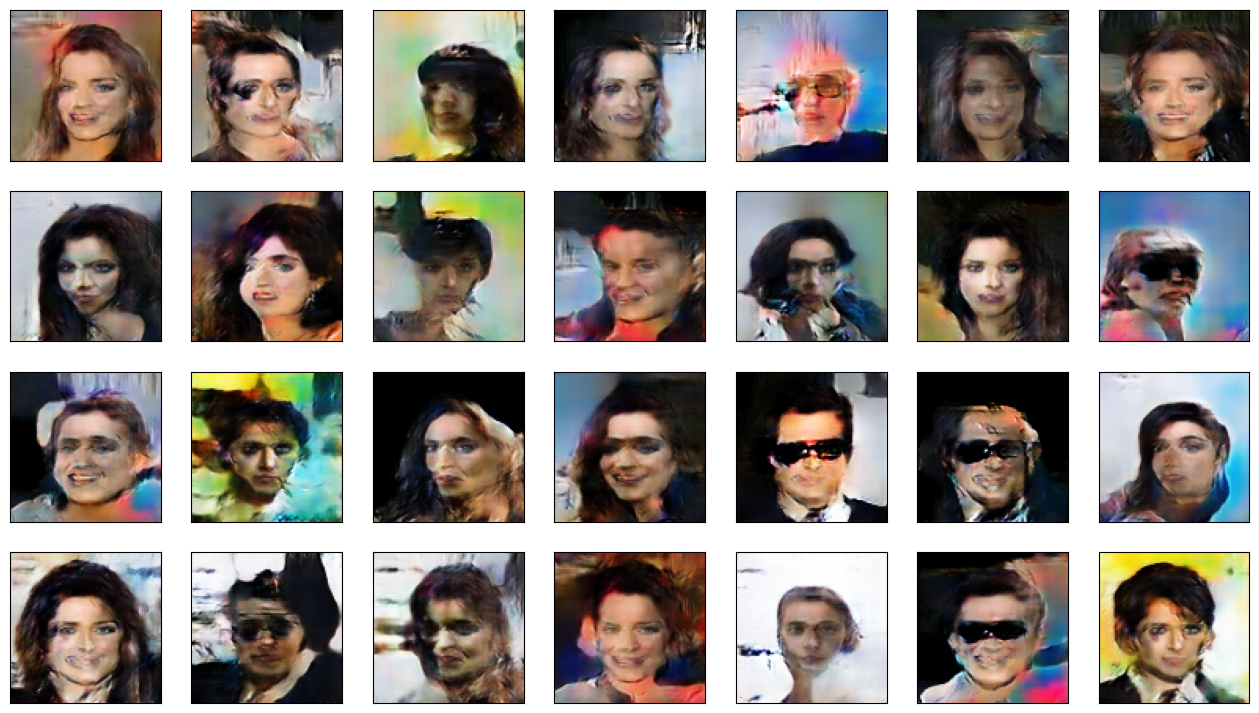

In [ ]:
# Generate images using the trained generator model
noise = tf.random.normal([PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE])
generated_images = generator.predict(noise)

# Rescale images
generated_images = 0.5 * generated_images + 0.5 

# Plot the generated images
fig, axes = plt.subplots(PREVIEW_ROWS, PREVIEW_COLS, figsize=(16, 9),
                          subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i])
    
plt.show()